<h1>Introduction</h1>

We wish to explore different methods of handling FX spot risk using two actors: a client trader and market maker.
In this demo we randomly generate trades for the client to execute against the market maker. The market maker can hedge exposure against a "world book" - which serves as an interbank market. If the cost of hedging in the interbank market is equal to the fees charged to the client by the market maker, the market maker will not generate any PnL without warehousing risk.
The entire demo will be based on simulated data.

The flow of the demo is as following:

1. Simulate data
2. Setup Client behavior
3. Setup Market Maker behavior
4. Run experiment




<h3> Simulation </h3>
The price data will be generated as a matrix of dimension ($ \text{Num_steps} \ \times \ \text{assets} $). First we simulate uncorrelated asset price increments $d\hat{W}$ as following:

$$ d\hat{W} = \sigma \ dt \ \mathcal{N}(0, 1) $$

We correlate add correlation by multiplying our metrix with the Cholesky Decomposition of the desired covariance matrix $\Sigma$ (See https://en.wikipedia.org/wiki/Cholesky_decomposition).
The row-wise commulated sums represents our price data.

In [29]:
import numpy as np
import pandas as pd
from generator import Generator

# SIMULATION
dt = 0.001  # Time step
num_steps = 2000  # Number of steps
vol = 0.1
grace_period = 200
time_line = np.arange(0, num_steps * dt, dt)[grace_period:]

# ASSETS
fx_crosses = ["EURUSD", "EURGBP", "EURSEK"]
start_rates = [1.11, 0.895, 9.2]

# DERIVED
value_dict = {"EUR": 1}
value_dict.update({fx_cross[-3:]: 1.0/rate for fx_cross, rate in list(zip(fx_crosses, start_rates))})

asset_names = list(value_dict)
start_values = list(value_dict.values())

# Correlation matrix
correlation_matrix = np.array([[1.0, 0.8, 0.3],
                               [0.8, 1.0, 0.3],
                               [0.3, 0.3, 1.0]])

# Generate X different assets with correlation matrix W
generator = Generator(fx_crosses)
data = generator.simulate_rates(start_rates, vol, dt, num_steps, correlation_matrix)
data

,EURUSD,EURGBP,EURSEK
time,,,
0.000,1.110000,0.895000,9.200000
0.001,1.109914,0.894947,9.200113
0.002,1.109906,0.894977,9.200170
0.003,1.109901,0.894980,9.200029
0.004,1.109918,0.894906,9.199829
...,...,...,...
1.995,1.109917,0.897724,9.195720
1.996,1.110088,0.897789,9.195641
1.997,1.110010,0.897715,9.195568


<Axes: xlabel='time'>

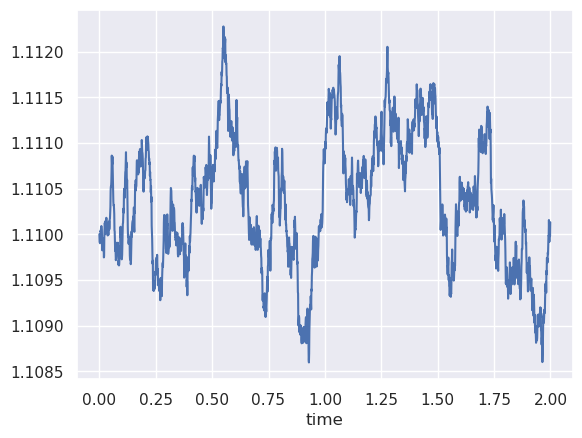

In [30]:
import seaborn as sns
sns.set_theme()
data['EURUSD'].plot()

/home/fsk/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


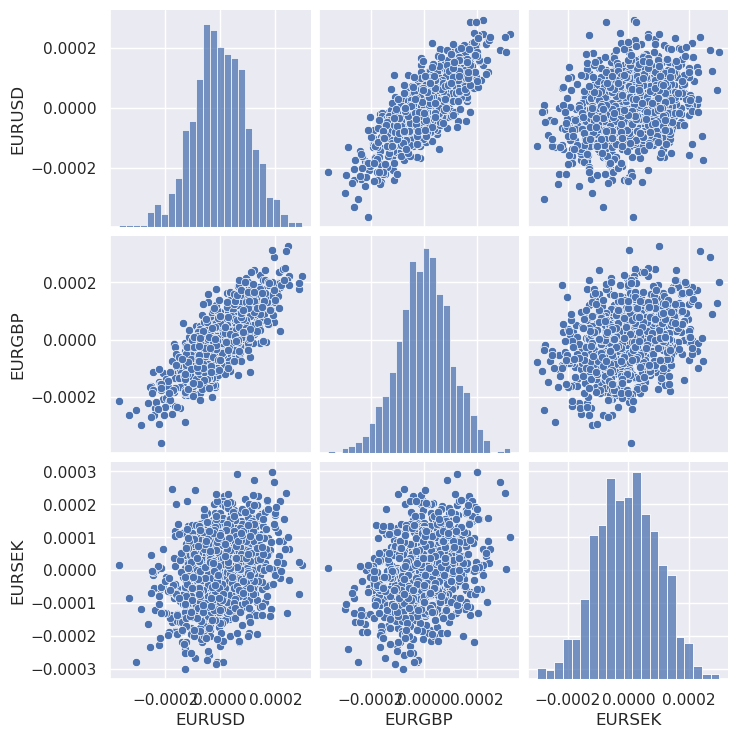

In [31]:
import plotting

plotting.plot_market_dX(data[:3]) # dont plot too many

<h3> Client Behavior </h3>
We set up a trader that randomly decides what to trade. For every time step, the trader randomly picks a uniformly distributed $U(0,1)$ number. If the number is below threshold, the trader decides to trade.
The nature of the trade will be decided by a normal distribution of dimension similar to amount of assets to trade:

$$ \text{Trade} =  \ \text{arg max}_{i \in \text{assets}} \ \ \ \mathcal{N}(\text{bias}, \sigma²_\text{trades})$$

The bias represents a bias towards buying or selling and variance determines the variance in the size of trades.

In [32]:
from trader import RandomTrader
from book import Book
# CLIENT PARAMETERS
# trigger parameters
threshold = 0.2
turns = num_steps

# trade parameters
bias = 0.0
variance = 1.0
size = 1

random_trader = RandomTrader(Book(asset_names))
random_trader.simulate_trades(time_line, fx_crosses, threshold, size, bias, variance)

,time,fx_cross,amount
0,0.203,EURUSD,-1.200602
1,0.207,EURGBP,-0.790765
2,0.211,EURSEK,1.215286
3,0.218,EURUSD,-0.973071
4,0.219,EURSEK,1.184133
...,...,...,...
377,1.985,EURUSD,1.720367
378,1.991,EURSEK,0.690212
379,1.992,EURUSD,0.355773
380,1.993,EURSEK,1.887137


<h3> Market Maker Behavior </h3>
The market maker will receive any trades executed by the client and charge a fee/spread to the rate traded at. We equip the market maker with a risk measure, such that it can quantity its current risk. In the demo we will use variance as risk such that the risk at a current time is given by the estimated covariance of price changes $\hat{\Sigma}$ and current position $w$:

$$\text{VarianceRisk} = w^T \hat\Sigma w$$

It is then possible to assign a hedging strategy that minimizes the following problem:

$$ \min ( \text{VarianceRisk} + \text{Hedging Costs} ) $$

If we let the hedge $h$ be the desired change in position such that $\hat w = w + h$, this becomes:

$$ \min ( \hat w^T \hat\Sigma \hat w + |\text{spread} \cdot h| ) $$

Where spread represents a vector of costs to hedge each position change in $h$. The cost-scaled length of the hedge vector, $|\text{spread} \cdot h|$, represents the cost to hedge.

For the demo we have added a minimum trade size such that our market maker does not hedge "trivially" sized positions.

In [33]:
from trader import MarketMaker, risk_minimizer
from risk import RiskMeasure, variance_risk
market_maker = MarketMaker(Book(asset_names))
# Risk measure as described above
market_maker.assign_risk_measure(risk_measure=RiskMeasure(variance_risk))
# Strategy should be to minimize risk + costs
market_maker.assign_strategy(risk_minimizer)
# parameters for solver
market_maker.set_internal_parameters({'scale_risk': 1.0,
                                      'scale_cost': 1.0,
                                      'scale_hedge': 1.0,
                                      'minimzer_method': 'SLSQP',
                                      'options': {'maxiter': 150},
                                      'tol': 10**(-15),
                                      'trade_theshold': 0.05})

<h3> Run Experiment </h3>
We definite the spread that the client will pay to the market maker, which is equivalent to the spread our market maker would pay in the "interbank" or "world" market. The "world maker" trader will be a risk sink that the market maker will offload risk to.

We include a "grace period" such that any esimated covariance $\hat\Sigma$ has a chance to materialize. Without this, the market maker would have no historical data to go by in the early stages of the experiment.

In [34]:
# cost to trade
# spread = 10.0/10.0**6 # eur/mio
spread = 1.96 * vol * dt/ np.sqrt(num_steps)

# cost to hedge
hedge_spread = 1.96 * vol * dt/ np.sqrt(num_steps)

# Create world-book to dump risk into
world_maker = MarketMaker(Book(asset_names))
world_maker.assign_risk_measure(risk_measure=RiskMeasure(variance_risk))

100%|███████████████████████████████████████| 1800/1800 [00:34<00:00, 51.59it/s]


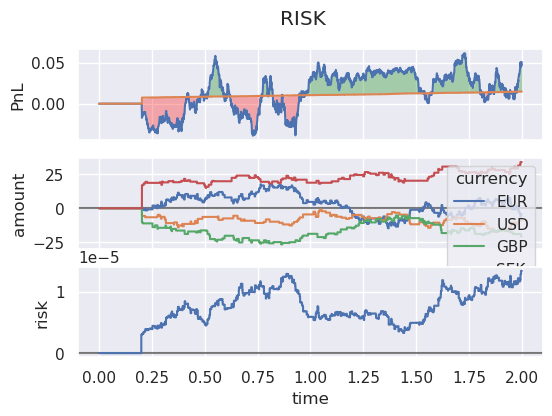

In [37]:
from tqdm import tqdm
import Utils as utils
from plotting import plot_trader_ccypair_pnl, plot_pnl_position_risk

for time in tqdm(time_line):
    # update market data
    market_data = data[data.index <= time]
    # the build current snap shot such that it is easier to send into trade functions
    current_state = market_data.reset_index().to_dict('records')[-1]
    # calc spreads   
    spreads = {key:spread*current_state[key] for key in list(current_state.keys())[1:]}    
    hedge_spreads = {key:hedge_spread*current_state[key] for key in list(current_state.keys())[1:]}    
    # IF HEDGER GOES FIRST, THAT MEANS A TURN HAS TO PASS FOR THE HEDGER TO REACT
    
    # #######################################################
    #
    #                   MARKET MAKER ACTION
    #
    # #######################################################
    
    # get hedges
    state = {'position': utils.currency_positions_to_pairs(positions=market_maker.book.get_position(), market_rates=dict(market_data.iloc[-1])),
            'market_data': market_data,
            'hedge_spreads': hedge_spreads}

    hedges = market_maker.get_reaction(state=state).to_dict('records')
    # trade = hedges.iloc[0]
    for trade in hedges:
        # print('Trade/Hedger:')
        # print(trade)
        market_maker.book.fx_trade(time=time
                                   ,target_book=world_maker.book
                                   ,fx_cross=trade['fx_cross']
                                   ,fx_rate=(current_state[trade['fx_cross']] + hedge_spreads[trade['fx_cross']] * np.sign(trade['amount'])) # fixed spread cost
                                   ,base_amount=trade['amount']
                                   ,pay_margin=hedge_spreads[trade['fx_cross']] * np.abs(trade['amount']))

    # #######################################################
    #
    #                   CLIENT ACTION
    #
    # #######################################################
    
    trades = random_trader.get_reaction(current_state).to_dict('records')
    # EXECUTE
    # trade = trades.iloc[0]
    for trade in trades:
        # print('Trade/Client:')
        # print(trade)
        random_trader.book.fx_trade(time=time
                                    ,target_book=market_maker.book
                                    ,fx_cross=trade['fx_cross']
                                    ,fx_rate=(current_state[trade['fx_cross']] + spreads[trade['fx_cross']] * np.sign(trade['amount'])) # fixed spread cost
                                    ,base_amount=trade['amount']
                                    ,pay_margin=spreads[trade['fx_cross']] * np.abs(trade['amount']))

    # get hedger risk measure
    state = {'position': utils.currency_positions_to_pairs(positions=market_maker.book.get_position(), market_rates=dict(market_data.iloc[-1])),
             'market_data': market_data}
    market_maker.book.log_risk_entry(time=time, risk=market_maker.risk_measure.evaluate_risk(state))
    
    # get world_maker risk
    state = {'position': utils.currency_positions_to_pairs(positions=world_maker.book.get_position(), market_rates=dict(market_data.iloc[-1])),
             'market_data': market_data}
    
    world_maker.book.log_risk_entry(time=time, risk=world_maker.risk_measure.evaluate_risk(state))
    # next turn
# Voila


plot_pnl_position_risk(trader=market_maker, market_data=market_data, asset_names=asset_names, scaling=utils.convert_to_eur(market_data.to_dict('records')[-1]))

The top plot shows the total PL for the Market Maker in blue with an orange line representing the margin earned from spread costs paid by the trader to the maker. We shade the difference between PL and margin to distinguish trade PL from margin PL.
In the second plot we show the € equivalent amount of exposure for each currency and lastly the percieved risk by our market maker.

Next we will plot the performance for a single currency pair traded by our client. We plot the price development of the asset and mark the buy/sell trades executed in market maker book. This includes both trades executed by the client against the maker and trades executed by market maker to hedge exposure.

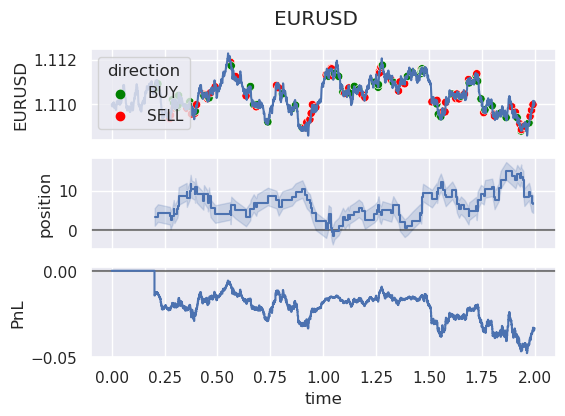

In [38]:
plot_trader_ccypair_pnl(market_maker, 'EURUSD', market_data, asset_names=asset_names)

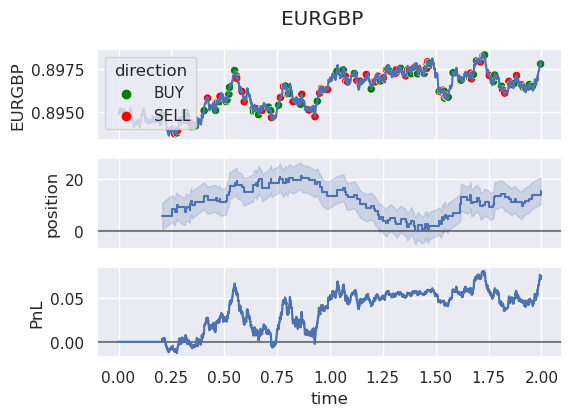

In [43]:
plot_trader_ccypair_pnl(market_maker, 'EURGBP', market_data, asset_names=asset_names)

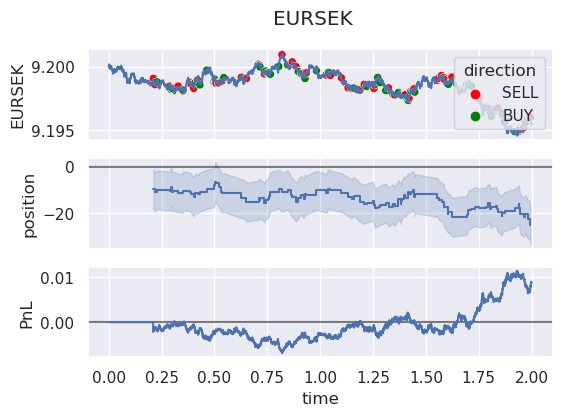

In [44]:
plot_trader_ccypair_pnl(market_maker, 'EURSEK', market_data, asset_names=asset_names)

<h3> Conclusion </h3>
Unforunately the minimize function does not currently behave well with current parameters - this results in zero hedges executed by the market maker. If any were made, we could display the trade by "world maker" to see what/when the maker decided to hedge.

A naive PCA based Back-to-Back hedger would be interesting as it would be able to reduce risk such that its perceived PCA transformed risk is zero, while hopefully saving on hedging cost as several assets might negate each others risk due to correlation.

This should not be difficult to code, but for now we leave this experiment with the plumbing "intact" and ready to be further improved upon in future if I want to.